# Apply HUX Mapping Technique to in-situ spacecraft observations


In [1]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate
import numpy as np
import scipy
import copy
import pickle
import math
import datetime as dt 

from heliopy.data import psp
from heliopy.data import omni
from heliopy.data import stereo
import heliopy.data.spice as spicedata
import heliopy.spice as spice
from astropy.coordinates import SkyCoord
import astropy.units as u
from heliopy.data.solo import download

from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable

from archimedes_sprial import cmap_spiral, compute_phi_shift_forward
from hux_propagation import *

# matplotlib fontsize
%matplotlib notebook
%matplotlib inline
fs1=12
plt.rcParams['savefig.facecolor'] = 'white'

# Read in global MHD model (MAS) solutions 
### CR 2210, 2215, 2221, 2226, 2231, 2235, and 2239 which contained each of the perihelia P1, P2, P3, P4, P5, P6, and P7, respectively.


# TODO: 
    1. Reach out to David or create your own function to sample sample from mhd solutions when r <30. 
    2. Uncertainity Quantification of the Initial conditions (Spacecraft observations). 
    3. Ballistic Approximation from given radial location of the messurement.

Download MAS solutions from [Predictive Science Inc. website](http://www.predsci.com/data/runs).

For more information about reading MHD solutions see [PsiPy documentation website](https://psipy.readthedocs.io/en/stable/guide/getting_started.html#getting-data).

In [2]:
# set up - perihelion p1-p7
case_study = "p1"


if case_study == "cr2211":
    # Carrington Rotation 2211
    # 2018 Nov 23	2018 Dec 20
    starttime = dt.datetime(year=2018, month=11, day=23)
    endtime = dt.datetime(year=2018, month=12, day=20)
    cr = "2211"

if case_study == "p1":
    # Carrington Rotation 2210
    # 2018 Oct 26	2018 Nov 23
    # Encounter 1 date: 2018-11-06. Distance from the center of the sun: 0.17 au (35.6 RS)
    starttime = dt.datetime(year=2018, month=10, day=26)
    endtime = dt.datetime(year=2018, month=11, day=23)
    cr = "2210"
    
elif case_study == "p2":
    # TODO: DEBUG OMNI DATASET LOAD FOR THIS TIME INTERVAL. 
    # Carrington Rotation 2215
    # 2019 Mar 12	2019 Apr 08
    # Encounter 2 date: 2019-04-04. Distance from the center of the sun: 0.17 au (35.6 RS)
    starttime = dt.datetime(year=2019, month=3, day=12)
    endtime = dt.datetime(year=2019, month=4, day=8)
    cr = "2215"
    
elif case_study == "p3":
    # Carrington Rotation 2221
    # 2019 Aug 22	2019 Sep 19
    # Encounter 3 date: 2019-09-01. Distance from the center of the sun: 0.17 au (35.6 RS)
    starttime = dt.datetime(year=2019, month=8, day=22)
    endtime = dt.datetime(year=2019, month=9, day=19)
    cr = "2221"

elif case_study == "p4":
    # todo: PSP VR DATA IS NOT AVAILABLE. 
    # Carrington Rotation 2226
    # 2020 Jan 06	2020 Feb 02
    # Encounter 4 date: 2020-01-29. Distance from the center of the sun: 0.13 au (27.8 RS)
    starttime = dt.datetime(year=2020, month=1, day=6)
    endtime = dt.datetime(year=2020, month=2, day=2)
    cr = "2226"
    
elif case_study == "p5":
    # Carrington Rotation 2231 
    # 2020 May 21	2020 Jun 18
    # Encounter 5 date: 2020-06-07. Distance from the center of the sun: 0.13 au (27.8 RS)
    starttime = dt.datetime(year=2020, month=5, day=21)
    endtime = dt.datetime(year=2020, month=6, day=18)
    cr = "2231"
    
    
elif case_study == "p6":
    # todo: PSP VR DATA IS NOT AVAILABLE. 
    # Carrington Rotation 2235 
    # 2020 Sep 07	2020 Oct 05
    # Encounter 6 date: 2020-09-27. Distance from the center of the sun: 0.09 au (20.3 RS)
    starttime = dt.datetime(year=2020, month=9, day=7)
    endtime = dt.datetime(year=2020, month=10, day=5)
    cr = "2235"

elif case_study == "p7":
    # todo: PSP VR DATA IS NOT AVAILABLE. 
    # Carrington Rotation 2239
    # 2020 Dec 25	2021 Jan 22
    # Encounter 7 date: 2021-01-17. Distance from the center of the sun: 0.09 au (20.3 RS)
    starttime = dt.datetime(year=2020, month=12, day=25)
    endtime = dt.datetime(year=2021, month=1, day=22)
    cr = "2239"

In [3]:
# mas output - br, rho, vr
mas_path = get_mas_path(cr=cr)

model = MASOutput(mas_path)

print(model.variables)

['br', 'rho', 'vr']


In [4]:
# read in MHD velocity results. 
vr_model = model['vr']

In [5]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
r = vr_model.r_coords
# velocity profile 
f = vr_model.data

In [6]:
print("Velocity matrix shape: ", np.shape(f))
print("Phi dim: ", np.shape(f)[0])
print("Theta dim: ", np.shape(f)[1])
print("Radial dim: ", np.shape(f)[2])
print("Velocity matrix dtype: ", f.dtype)


Velocity matrix shape:  (128, 111, 140)
Phi dim:  128
Theta dim:  111
Radial dim:  140
Velocity matrix dtype:  float32


In [7]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p_plot = np.append(p, 2*np.pi) 

# Phi: from radians to degrees. longitude.
p_plot = (180/np.pi)*p_plot

In [8]:
# append the first slice p=0 to velocity matrix. 
f_plot = np.append(f,[f[0,:, :]],axis=0)

In [9]:
# Radius: from solar radii to km. 
# 1 solar radii = 695,700 km
r_plot = (695700)*r

In [10]:
# convert to sin(Lat.) [-1, 1]
t_plot = np.sin(t)

In [11]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p_plot[0]], 0.5 * (p_plot[1:] + p_plot[:-1]), [p_plot[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

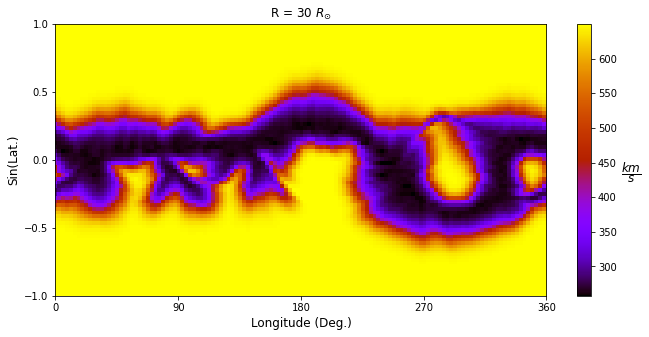

In [12]:
fig, ax = plt.subplots(figsize = (11,5))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 30 $R_{\odot}$", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
#plt.savefig('figures/' + case_study + '/vr_30rs_map.png')

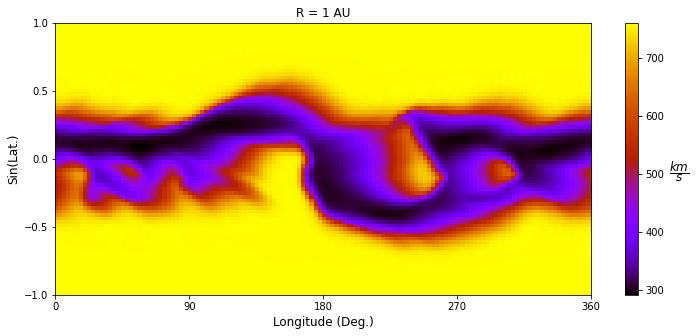

In [13]:
fig, ax = plt.subplots(figsize = (12,5))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 1 AU", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
#plt.savefig('figures/' + case_study + '/vr_1au_map.png')

# Apply Heliospheric Upwind eXtrapolation method 

The HUX underlying PDE (Simplified fluid momentum equation in a corotating frame of reference):

$$
-\Omega_{rot}\frac{\partial v_{r}}{\partial \phi} + v_{r}\frac{ \partial v_{r}}{\partial r}=0
$$

With the initial condition 
$$
v_{r}(\phi, r_{0}) = v_{r0}(\phi)
$$

The HUX-f technique leverages the forward upwind difference method, such that
$$
-\Omega_{rot} \frac{v_{i, j+1} - v_{i, j}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i+1, j} - v_{i, j}}{\Delta r}) = 0
$$


$$
v_{i+1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{v_{i, j}}  (\frac{v_{i, j+1} - v_{i, j}}{\Delta \phi})
$$

Whereas HUX-b technique leverages the backwards finite difference approximation, such that 

$$
-\Omega_{rot} \frac{v_{i, j} - v_{i, j-1}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i, j} - v_{i-1, j}}{\Delta r}) = 0
$$


$$
v_{i-1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{v_{i, j}}  (\frac{v_{i, j}-v_{i, j-1}}{\Delta \phi})
$$

where for simplicity the $r$ subscipt on the radial velocity is omitted. The indicies $i$ and $j$ refer to $r$ and $\phi$ grids repectively in HG coordinates. 



# References

[1] Riley P and Lionello R (2011) "Mapping Solar Wind Streams from the Sun to 1 AU: A Comparison of Techniques". Solar Phys.270, 575–592. 

[2] Riley P and Issan O (2021) "Using a Heliospheric Upwinding eXtrapolation Technique to Magnetically Connect Different Regions of the Heliosphere". Front. Phys. 9:679497.

In [14]:
# get solar equator slices and save delta r and delta p arrays for hux propagation. 
solar_equator_r_30_radii = f[:, 55, 0]
solar_equator_r_1_au = f[:, 55, -1]
dr_vec = r_plot[1:] - r_plot[:-1]
dp_vec = p[1:] - p[:-1]

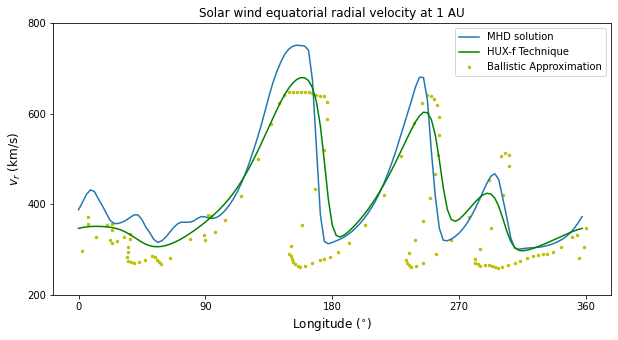

In [15]:
fig, ax = plt.subplots(figsize = (10,5))

_ = ax.plot(p*180/np.pi, solar_equator_r_1_au, label="MHD solution")
_ = ax.plot(p*180/np.pi, apply_forward_upwind_model(solar_equator_r_30_radii, dr_vec, dp_vec),
            'g',label="HUX-f Technique")

_ = ax.scatter(apply_ballistic_approximation(np.array(solar_equator_r_30_radii), 
                r_plot[-1] - r_plot[0], p)*180/np.pi, 
                solar_equator_r_30_radii, 
                color='y',s = 6, label="Ballistic Approximation")
            
_ = ax.set_title("Solar wind equatorial radial velocity at 1 AU",fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])

_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
#plt.savefig('figures/' + case_study + '/vr_1AU_ts_comp_MHD_HUX-f.png')

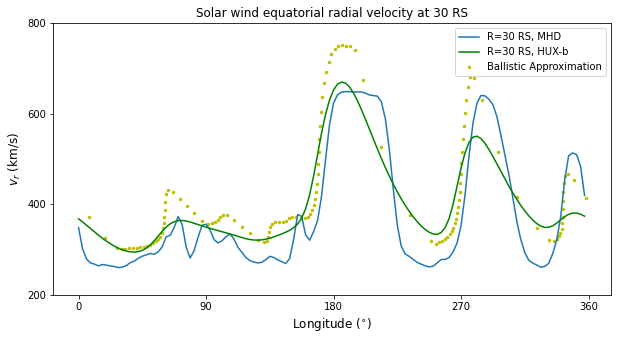

In [16]:
fig, ax = plt.subplots(figsize = (10,5))

_ = ax.plot(p*180/np.pi, solar_equator_r_30_radii , label="R=30 RS, MHD")
_ = ax.plot(p*180/np.pi, apply_backwards_upwind_model(solar_equator_r_1_au, dr_vec, dp_vec),
            'g',label="R=30 RS, HUX-b")


_ = ax.scatter(apply_ballistic_approximation(np.array(solar_equator_r_1_au), 
                r_plot[0]- r_plot[-1], p)*180/np.pi, 
                solar_equator_r_1_au, 
                color='y',s=6, label="Ballistic Approximation")

_ = ax.set_title("Solar wind equatorial radial velocity at 30 RS",fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
#plt.savefig('figures/' + case_study + '/vr_30RS_ts_comp_MHD_HUX-b_cr' + str(cr) +'.png')

In [17]:
# apply the hux technique to all theta slices
hux_f_res, hux_b_res = np.ones((len(p), len(t), len(r))),  np.ones((len(p), len(t), len(r)))
for ii in range(len(t)):
    hux_f_res[:, ii, :] = apply_hux_f_model(f[:, ii, 0], dr_vec, dp_vec).T
    hux_b_res[:, ii, :] = apply_hux_b_model(f[:, ii, -1], dr_vec, dp_vec).T

In [18]:
# force periodicity when plotting
hux_f_res_plot = np.append(hux_f_res,[hux_f_res[0, :, :]], axis=0)
hux_b_res_plot = np.append(hux_b_res,[hux_b_res[0, :, :]], axis=0)

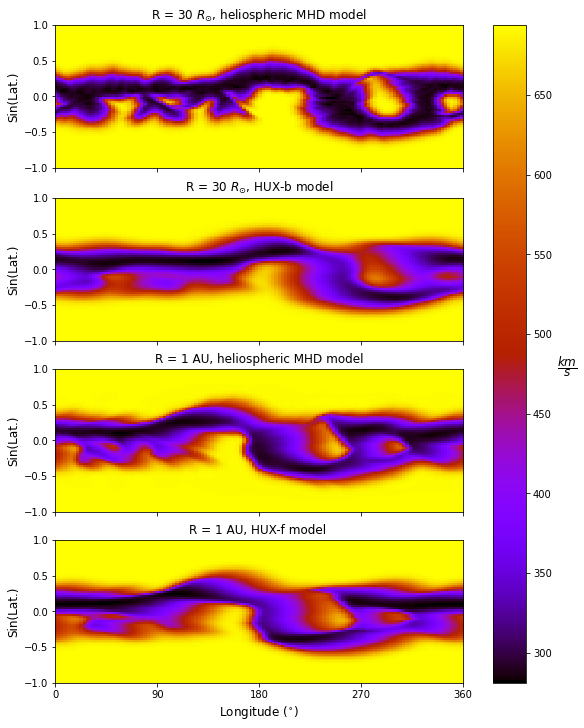

In [19]:
plt.rcParams['figure.figsize'] = [8, 10] # default fig size.

fig, ax = plt.subplots(nrows=4, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_ylim(-1, 1)
ax[0].set_xlim(0, 360)
ax[0].set_title("R = 30 $R_{\odot}$, heliospheric MHD model", fontsize=fs1)
ax[0].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[0].pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)

ax[1].set_ylim(-1, 1)
ax[1].set_xlim(0, 360)
ax[1].set_title("R = 30 $R_{\odot}$, HUX-b model", fontsize=fs1)
ax[1].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[1].pcolorfast(ph, th, hux_b_res_plot[:, :, 0].T, cmap=cmap)


ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 360)
ax[2].set_title("R = 1 AU, heliospheric MHD model", fontsize=fs1)
ax[2].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[2].pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)


ax[3].set_ylim(-1, 1)
ax[3].set_xlim(0, 360)
ax[3].set_title("R = 1 AU, HUX-f model ", fontsize=fs1)
ax[3].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[3].set_xlabel("Longitude ($^{\circ}$)", fontsize=fs1)
ax[3].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[3].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[3].pcolorfast(ph, th, hux_f_res_plot[:, :, -1].T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax.flat)
cbar.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)

#plt.savefig('figures/' + case_study + '/vr_lon_lat_maps_MHD_HUX.png')

# Read in Parker Solar Probe (PSP) observations

Here we load the merged magnetic field and plasma data product, which has
an hourly data cadence.

In [20]:
psp_data = psp.merged_mag_plasma(starttime, endtime)
print("Available data = ", psp_data.columns)

Available data =  ['radialDistance', 'heliographicLatitude', 'heliographicLongitude', 'BR', 'BT', 'BN', 'B', 'VR', 'VT', 'VN', 'ProtonSpeed', 'flow_theta', 'flow_lon', 'protonDensity', 'protonTemp']


In [21]:
psp_data.data

,radialDistance,heliographicLatitude,heliographicLongitude,BR,BT,BN,B,VR,VT,VN,ProtonSpeed,flow_theta,flow_lon,protonDensity,protonTemp
Time,,,,,,,,,,,,,,,
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0


Generate the PSP trajectory in Heliographic (rotating) Coordinate System (HG).

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.

In [22]:
times = psp_data.index

spicedata.get_kernel('psp')
spicedata.get_kernel('psp_pred')
psp_traj = spice.Trajectory('SPP')
psp_traj.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
psp_coords = psp_traj.coords

Here we sample the MHD and HUX velocity results at PSP location. 


In [23]:
hux_f_model = copy.deepcopy(vr_model)
hux_f_model.data.data = hux_f_res

hux_b_model = copy.deepcopy(vr_model)
hux_b_model.data.data = hux_b_res

In [24]:
vr_sampled_hux_f = hux_f_model.sample_at_coords(psp_coords.lon,
                                                psp_coords.lat,
                                                psp_coords.radius)

vr_sampled_hux_b = hux_b_model.sample_at_coords(psp_coords.lon,
                                                psp_coords.lat,
                                                psp_coords.radius)

vr_sampled_mhd = vr_model.sample_at_coords(psp_coords.lon,
                                           psp_coords.lat,
                                           psp_coords.radius)

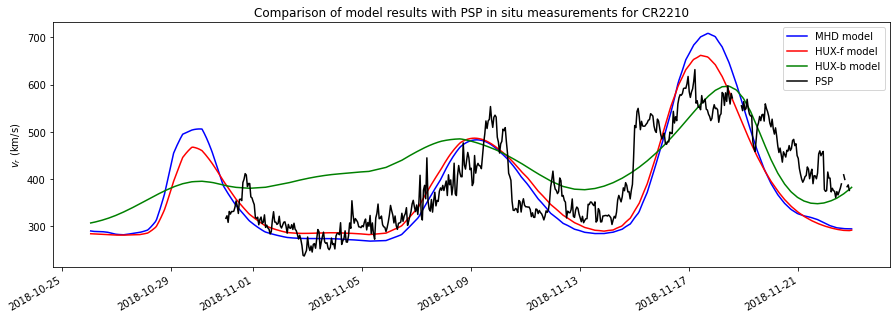

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(times, vr_sampled_mhd, color="b", label='MHD model')
ax.plot(times, vr_sampled_hux_f, color="r",label='HUX-f model')
ax.plot(times, vr_sampled_hux_b, color="g",label='HUX-b model')
ax.plot(times, psp_data.quantity('VR'), color="k", label='PSP')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of model results with PSP in situ measurements for CR" + str(cr))
fig.autofmt_xdate()

#plt.savefig('figures/'+ case_study + '/psp_comparison_cr'+ str(cr)+ '_time.png')

216


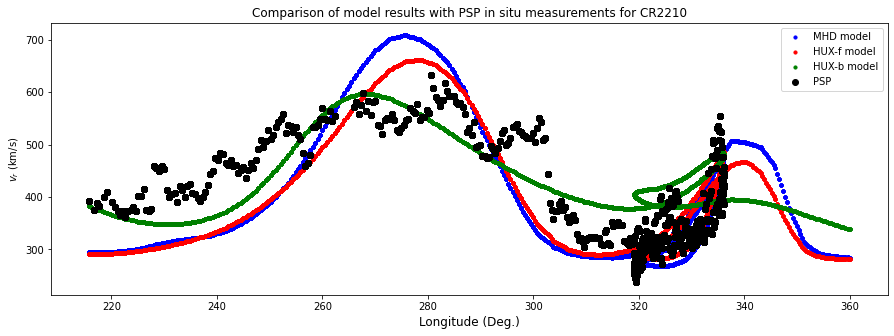

In [26]:
lon_psp = np.array(psp_coords.lon)

max_indx=np.argmax(psp_coords.lon)
print(max_indx)
add_periodicity =0

fig, ax = plt.subplots(figsize=(15, 5))
size = 10

#ax.scatter(lon_psp[:max_indx]+ add_periodicity, vr_sampled_mhd[:max_indx], color="b", s=size, label="MHD model")
#ax.scatter(lon_psp[:max_indx]+ add_periodicity, vr_sampled_hux_f[:max_indx], color="r", s=size, label="HUX-f model")
#ax.scatter(lon_psp[:max_indx]+ add_periodicity, vr_sampled_hux_b[:max_indx], color="g",s=size,  label="HUX-b model")
#ax.scatter(lon_psp[:max_indx]+ add_periodicity, psp_data.quantity('VR')[:max_indx], color="k",s=size,  label="PSP")

ax.scatter(lon_psp[max_indx:], vr_sampled_mhd[max_indx:], s=size, color="b", label="MHD model")
ax.scatter(lon_psp[max_indx:], vr_sampled_hux_f[max_indx:], s=size, color="r", label="HUX-f model")
ax.scatter(lon_psp[max_indx:], vr_sampled_hux_b[max_indx:], s=size, color="g", label="HUX-b model")
ax.scatter(lon_psp[max_indx:], psp_data.quantity('VR')[max_indx:], color="k",  label="PSP")


ax.set_ylabel(r'$v_{r}$ (km/s)')
#ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_title("Comparison of model results with PSP in situ measurements for CR" + str(cr))
ax.legend()
#plt.savefig('figures/'+ case_study + '/psp_comparison_cr' + str(cr) + '_carrington_longitude.png')

# Read in OMNI (Earth) Observations

• OMNI data set for solar wind speed observations can be found https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/

In [27]:
omni_data = omni.h0_mrg1hr(starttime, endtime)

In [28]:
omni_data.data

,Epoch_1800,Rot1800,IMF1800,PLS1800,IMF_PTS1800,PLS_PTS1800,ABS_B1800,F1800,THETA_AV1800,PHI_AV1800,...,F10_INDEX,KP,DST,AE,AP_INDEX,AL_INDEX,AU_INDEX,PC_N_INDEX,Solar_Lyman_alpha,Proton_QI
Time,,,,,,,,,,,,,,,,,,,,,
2018-10-26 01:00:00,6.370774e+13,2526,51,52,59,33,5.3,4.6,5.800000,153.600006,...,68.300003,20,-3,9999,7,99999,99999,1.1,0.006018,0.0130
2018-10-26 02:00:00,6.370774e+13,2526,51,52,61,37,5.0,4.3,23.299999,176.800003,...,68.300003,20,2,9999,7,99999,99999,0.2,0.006018,0.0117
2018-10-26 03:00:00,6.370774e+13,2526,51,52,62,36,4.8,4.6,28.000000,123.199997,...,68.300003,13,6,9999,5,99999,99999,0.2,0.006018,0.0091
2018-10-26 04:00:00,6.370775e+13,2526,51,52,61,37,2.2,2.0,4.400000,144.500000,...,68.300003,13,11,9999,5,99999,99999,0.5,0.006018,0.0011
2018-10-26 05:00:00,6.370775e+13,2526,51,52,60,31,2.2,1.9,-1.900000,194.500000,...,68.300003,13,12,9999,5,99999,99999,0.2,0.006018,0.0010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-22 19:00:00,6.371013e+13,2527,51,52,61,34,4.3,4.1,23.200001,332.399994,...,67.500000,3,-2,9999,2,99999,99999,0.1,0.005990,0.0257
2018-11-22 20:00:00,6.371014e+13,2527,51,52,61,36,4.4,4.2,14.100000,316.000000,...,67.500000,3,-1,9999,2,99999,99999,0.0,0.005990,0.0313
2018-11-22 21:00:00,6.371014e+13,2527,51,52,64,39,4.2,3.3,2.200000,264.000000,...,67.500000,0,3,9999,0,99999,99999,0.1,0.005990,0.0152


Generate the OMNI (Earth) trajectory in Heliographic (rotating) Coordinate System (HG).

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.

In [29]:
earth_traj = spice.Trajectory('Earth')
earth_traj.generate_positions(times=omni_data.index, observing_body='Sun', frame='IAU_SUN')
earth_coords = earth_traj.coords

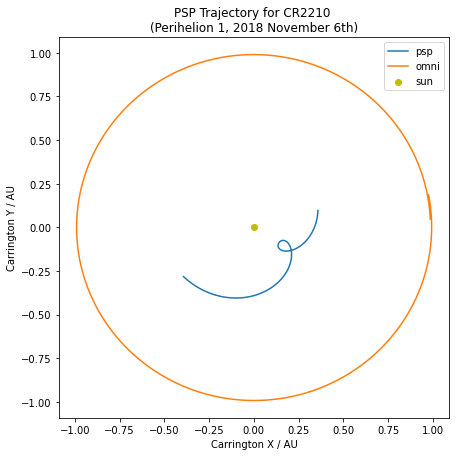

In [30]:
fig, ax = plt.subplots(figsize=(7, 7))
_ = ax.plot(psp_coords.radius.to("AU")* np.cos(lon_psp*np.pi/180), psp_coords.radius.to("AU")* np.sin(lon_psp*np.pi/180), label="psp")
_ = ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="omni")
_ = ax.scatter(0, 0, color="y", label="sun")
#_ = ax.set_xlim(-1, 1)
#_ = ax.set_ylim(-1, 1)
_ = ax.set_xlabel("Carrington X / AU")
_ = ax.set_ylabel("Carrington Y / AU")
_ = ax.legend()
_ = ax.set_title("PSP Trajectory for CR2210 \n(Perihelion 1, 2018 November 6th)")
# plt.savefig('figures/'+ case_study + '/psp_cr2210_trajectory_location.png')

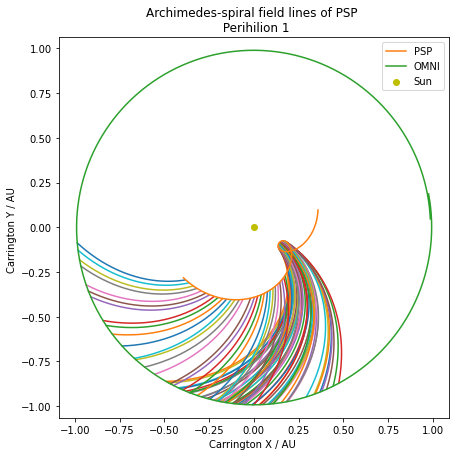

In [33]:
nphi = len(lon_psp)
nrout = 201
earth_mean_r = np.mean(earth_coords.radius.to("AU").value)

fig, ax = plt.subplots(figsize=(7, 7))
for ii in np.arange(0, nphi, 150):
    phi_location = (lon_psp[ii])*(np.pi/180)
    radial_location = np.linspace(psp_coords.radius.to("AU").value[ii], earth_mean_r, nrout)
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    curr_velocity = psp_data.quantity('VR').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 

        x = np.cos(phi_shift_vec)*radial_location.to(u.AU)
        y = np.sin(phi_shift_vec)*radial_location.to(u.AU)

        _ = ax.plot(x[1:], y[1:])

ax.plot(psp_coords.radius.to("AU")* np.cos(lon_psp*np.pi/180), psp_coords.radius.to("AU")* np.sin(lon_psp*np.pi/180), label="PSP")
ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="OMNI")
ax.scatter(0, 0, color="y", label="Sun")
ax.set_title("Archimedes-spiral field lines of PSP \n Perihilion 1")
ax.set_xlabel("Carrington X / AU ")
ax.set_ylabel("Carrington Y / AU ")
plt.axis("equal")
plt.legend()

plt.savefig('figures/'+ case_study + '/Archimedes_spiral_psp.png')

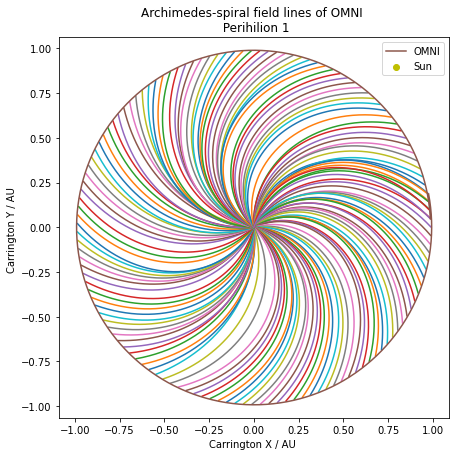

In [34]:
fig, ax = plt.subplots(figsize=(7, 7))
for ii in np.arange(0, len(earth_coords.lon), 5):
    phi_location = (earth_coords.lon.value[ii])*(np.pi/180)
    radial_location = np.linspace(earth_coords.radius.to("AU").value[ii], 0, nrout)
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    curr_velocity = omni_data.quantity('V').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 

        x = np.cos(phi_shift_vec)*radial_location.to(u.AU)
        y = np.sin(phi_shift_vec)*radial_location.to(u.AU)

        _ = ax.plot(x[1:], y[1:])

#ax.plot(psp_coords.radius.to("AU")* np.cos(lon_psp*np.pi/180), psp_coords.radius.to("AU")* np.sin(lon_psp*np.pi/180), label="PSP")
ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="OMNI")
ax.scatter(0, 0, color="y", label="Sun")
ax.set_title("Archimedes-spiral field lines of OMNI \n Perihilion 1")
ax.set_xlabel("Carrington X / AU ")
ax.set_ylabel("Carrington Y / AU ")
plt.axis("equal")
plt.legend()

plt.savefig('figures/'+ case_study + '/Archimedes_spiral_omni.png')

In [35]:
vr_sampled_hux_f_omni = hux_f_model.sample_at_coords(earth_coords.lon,
                                                     earth_coords.lat,
                                                     earth_coords.radius)

vr_sampled_hux_b_omni = hux_b_model.sample_at_coords(earth_coords.lon,
                                                     earth_coords.lat,
                                                     earth_coords.radius)

vr_sampled_mhd_omni = vr_model.sample_at_coords(earth_coords.lon,
                                                earth_coords.lat,
                                                earth_coords.radius)

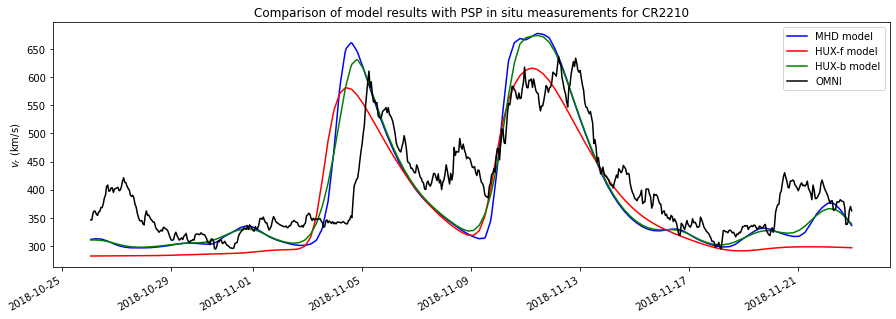

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(omni_data.index, vr_sampled_mhd_omni, color="b", label='MHD model')
ax.plot(omni_data.index, vr_sampled_hux_f_omni, color="r", label='HUX-f model')
ax.plot(omni_data.index, vr_sampled_hux_b_omni, color="g", label='HUX-b model')
ax.plot(omni_data.index, omni_data.quantity('V'),color="k", label='OMNI')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of model results with PSP in situ measurements for CR2210")
fig.autofmt_xdate()

#plt.savefig('figures/'+ case_study + '/omni_comparison_cr' + str(cr) + '_time.png')

In [37]:
min_index = np.argmin(earth_coords.lon)

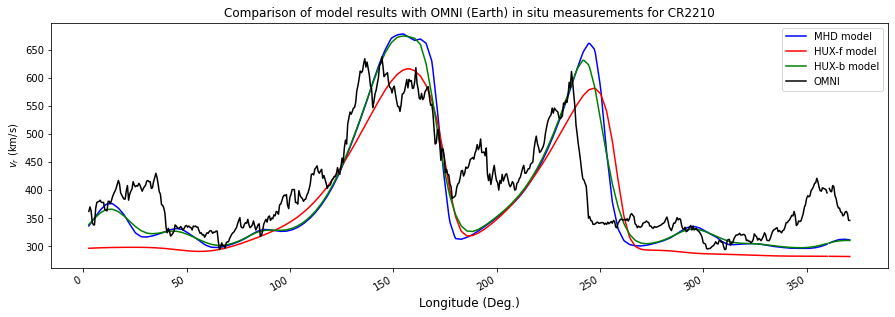

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_mhd_omni[:min_index], color="b", label="MHD model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_hux_f_omni[:min_index], color="r", label="HUX-f model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_hux_b_omni[:min_index], color="g", label="HUX-b model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, omni_data.quantity('V')[:min_index], color="k", label="OMNI")

ax.plot(earth_coords.lon[min_index+1:], vr_sampled_mhd_omni[min_index+1:], color="b")
ax.plot(earth_coords.lon[min_index+1:], vr_sampled_hux_f_omni[min_index+1:], color="r")
ax.plot(earth_coords.lon[min_index+1:], vr_sampled_hux_b_omni[min_index+1:], color="g")
ax.plot(earth_coords.lon[min_index+1:], omni_data.quantity('V')[min_index+1:], color="k")

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.legend()
ax.set_title("Comparison of model results with OMNI (Earth) in situ measurements for CR" + str(cr))
fig.autofmt_xdate()

#plt.savefig('figures/'+ case_study + '/omni_comparison_cr' + str(cr) + '_lon.png')

# Mapping PSP to OMNI (Earth) using the HUX-f and Ballistic Technique

# Assumptions: 
#### 1.  Latitude is constant in PSP trajectory coordinates 
* Note that HUX is dependent on $\phi$ and $r$ only. 

#### 2.  PSP and Earth are aligned in latitude. 
#### 3.  $\phi$ is monotonically increasing - notice that in perihelion 1 psp orbit loops back. 


#### 4. Periodic Boundary Conditions

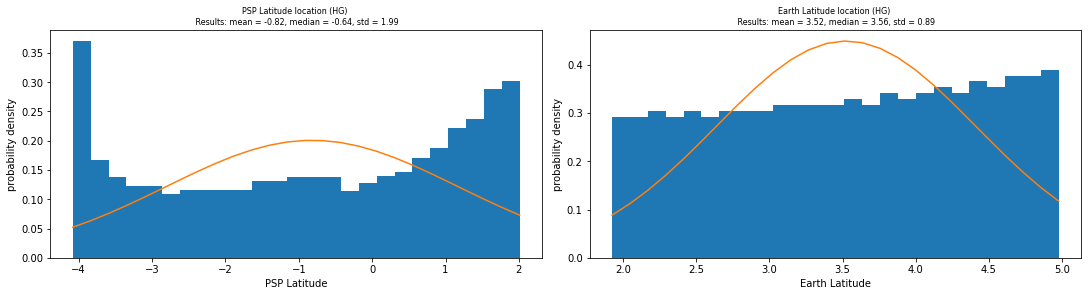

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 4))


## psp latitude trajectory 
mu, sigma = scipy.stats.norm.fit(psp_traj.coords.lat.value)

n , bins, _ = ax[0].hist(psp_traj.coords.lat.value, 25, density=1)
_ = ax[0].set_title("PSP Latitude location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(psp_traj.coords.lat.value), sigma), fontsize=8)
_ = ax[0].set_xlabel("PSP Latitude")
_ = ax[0].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[0].plot(bins, best_fit_line)


## earth latitude trajectory 
mu, sigma = scipy.stats.norm.fit(earth_traj.coords.lat.value)

n , bins, _ = ax[1].hist(earth_traj.coords.lat.value, 25, density=1)
_ = ax[1].set_title("Earth Latitude location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(earth_traj.coords.lat.value), sigma), fontsize=8)
_ = ax[1].set_xlabel("Earth Latitude")
_ = ax[1].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[1].plot(bins, best_fit_line)

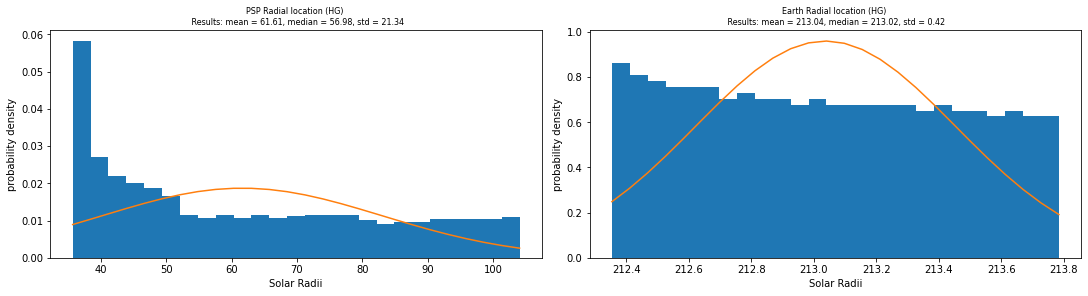

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 4))


## psp radial trajectory 
mu, sigma = scipy.stats.norm.fit(psp_traj.coords.radius.to(u.solRad).value)

n , bins, _ = ax[0].hist(psp_traj.coords.radius.to(u.solRad).value, 25, density=1)
_ = ax[0].set_title("PSP Radial location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(psp_traj.coords.radius.to(u.solRad).value), sigma), fontsize=8)
_ = ax[0].set_xlabel("Solar Radii")
_ = ax[0].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[0].plot(bins, best_fit_line)


## earth radial trajectory 
mu, sigma = scipy.stats.norm.fit(earth_traj.coords.radius.to(u.solRad).value)

n , bins, _ = ax[1].hist(earth_traj.coords.radius.to(u.solRad).value, 25, density=1)
_ = ax[1].set_title("Earth Radial location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(earth_traj.coords.radius.to(u.solRad).value), sigma), fontsize=8)
_ = ax[1].set_xlabel("Solar Radii")
_ = ax[1].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[1].plot(bins, best_fit_line)

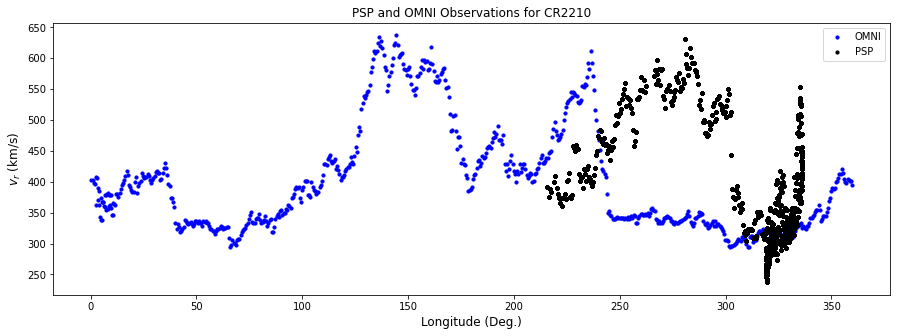

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))

_ = ax.scatter(earth_coords.lon, omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.scatter(psp_coords.lon, psp_data.quantity('VR'), color="k", s=size, label="PSP")

_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()
_ = ax.set_title("PSP and OMNI Observations for CR" + str(cr))
#plt.savefig('figures/'+ case_study + '/omni_and_psp_vr_vs_carringtonlon' + str(cr) +'.png')

# Ballistic Mapping
 * Evaluate the characteristic lines - do they intersect? This happens when the PSP velocity function is decreasing. Otherwise, when the PSP velocity function is increasing it results in rarefaction wave. 
 

In [42]:
r_mean = np.linspace(np.mean(psp_coords.radius), np.mean(earth_coords.radius), 100)
r_min = np.linspace(np.min(psp_coords.radius), np.mean(earth_coords.radius), 100)
r_max = np.linspace(np.max(psp_coords.radius), np.mean(earth_coords.radius), 100)

In [43]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

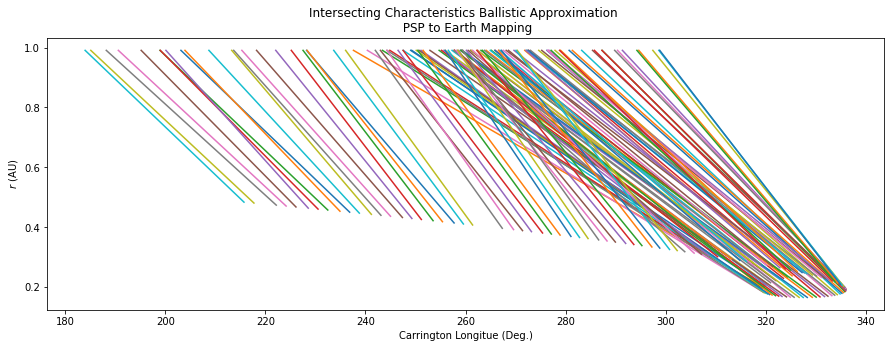

In [44]:
fig, ax = plt.subplots(figsize = (15,5))


for ii in np.arange(0, nphi, 100):
    phi_location = (lon_psp[ii])*(np.pi/180)
    radial_location = np.linspace(psp_coords.radius.to("AU").value[ii], earth_mean_r, nrout)
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    curr_velocity = psp_data.quantity('VR').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 
        _ = ax.plot(phi_shift_vec*(180/np.pi), radial_location.to(u.AU))

_ = ax.set_xlabel("Carrington Longitue (Deg.)")
_ = ax.set_ylabel("$r$ (AU)")
_ = ax.set_title("Intersecting Characteristics Ballistic Approximation \n PSP to Earth Mapping")

In [68]:
res_ballistic_f = np.zeros(nphi)
omega_rot=(2 * np.pi) / (25.38 * 86400)

for ii in range(nphi):
    phi_location = (lon_psp[ii])*(np.pi/180)
    r0 = psp_coords.radius.value[ii]
    rf = earth_mean_r *(u.AU)
    rf = rf.to(u.km).value
    curr_velocity = psp_data.quantity('VR').value[ii]
    dr = rf - r0
    delta_phi = (omega_rot * dr) / curr_velocity
    phi_shifted = phi_location - delta_phi
    # force periodicity
    res_ballistic_f[ii] = phi_shifted % (2 * np.pi)

<ipython-input-68-e03de64365f2>:14: RuntimeWarning: invalid value encountered in double_scalars
  res_ballistic_f[ii] = phi_shifted % (2 * np.pi)


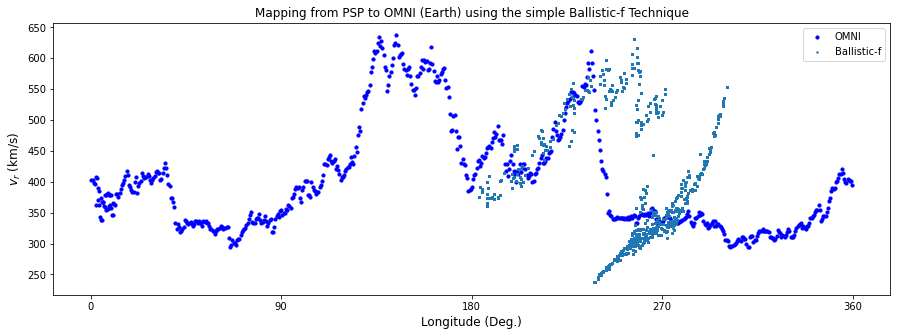

In [70]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.scatter(res_ballistic_f*(180/np.pi), psp_data.quantity('VR'),s=2, label="Ballistic-f")

_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from PSP to OMNI (Earth) using the simple Ballistic-f Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()


# HUX-f Technique
# 1D interpolation - input $\phi$ ranges from [0, 2$\pi$]

In [61]:
# get longitude limits
min_lon = np.inf
max_lon = -np.inf

for ii in range(len(psp_coords.lon.value)):
    if psp_coords.lon.value[ii] < min_lon and not math.isnan(psp_data.quantity('VR').value[ii]):
        min_lon = psp_coords.lon.value[ii]
    if psp_coords.lon.value[ii] > max_lon and not math.isnan(psp_data.quantity('VR').value[ii]):
        max_lon = psp_coords.lon.value[ii]

In [49]:
# create uniform phi 1d mesh grid. 

phi_array = np.linspace(0, 360, 361)

In [50]:
# drop NaNs
nan_idx = np.isfinite(psp_data.quantity('VR').value)
v_vec = psp_data.quantity('VR').value[nan_idx]
interp = interpolate.interp1d(psp_coords.lon.value[nan_idx], \
                              v_vec, fill_value=(400, 400),  bounds_error=False)
psp_interp = interp(phi_array)

C:\Users\Opali\AppData\Local\Continuum\anaconda3\envs\huxv1\lib\site-packages\scipy\interpolate\interpolate.py:623: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [51]:
# convert to radians
p_hux = phi_array * np.pi/180
# delta phi 
dp_vec_hux = p_hux[1:] - p_hux[:-1]

(215.70859456700973, 336.0822784520752)

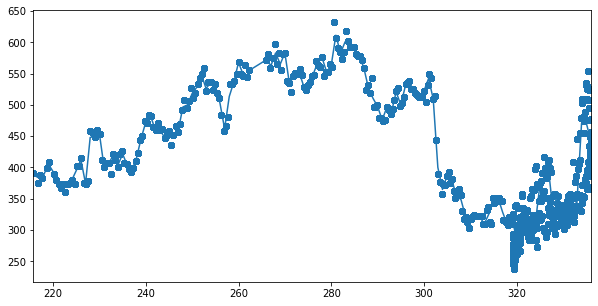

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(phi_array, psp_interp)
ax.scatter(psp_coords.lon.value, psp_data.quantity('VR').value)
ax.set_xlim(min_lon, max_lon)


In [56]:
res_hux_f_min = apply_forward_upwind_model(r_initial=psp_interp,
                                        dr_vec=r_min.value[1:] - r_min.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_min[0].value)


res_hux_f_max = apply_forward_upwind_model(r_initial=psp_interp,
                                        dr_vec=r_max.value[1:] - r_max.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_max[0].value)


res_hux_f_mean = apply_forward_upwind_model(r_initial=psp_interp,
                                        dr_vec=r_mean.value[1:] - r_mean.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_mean[0].value)

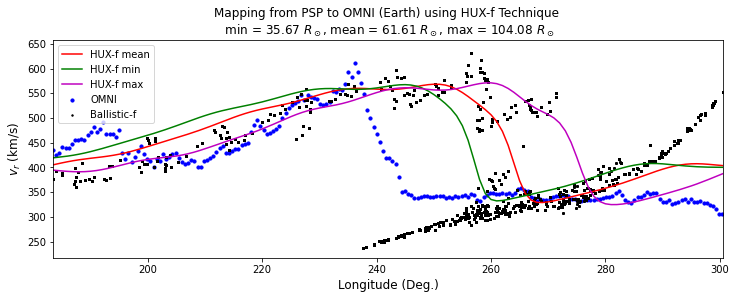

In [71]:
fig, ax = plt.subplots(figsize=(12,4))
_ = ax.scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean")
_ = ax.plot(phi_array, res_hux_f_min, color="g", label="HUX-f min")
_ = ax.plot(phi_array, res_hux_f_max, color="m", label="HUX-f max")

_ = ax.scatter(res_ballistic_f*(180/np.pi), psp_data.quantity('VR').value, s=2, c="k", label="Ballistic-f")

_ = ax.set_xlim(np.nanmin(res_ballistic_f*(180/np.pi)), np.nanmax(res_ballistic_f*(180/np.pi)))

_ = ax.set_title("Mapping from PSP to OMNI (Earth) using HUX-f Technique \n min = %.2f $R_\odot$, mean = %.2f $R_\odot$, max = %.2f $R_\odot$" % \
                       (np.min(psp_coords.radius).to(u.solRad).value,
                        np.mean(psp_coords.radius).to(u.solRad).value,
                        np.max(psp_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

# Map OMNI to PSP using the HUX-b and Ballistic Techniques

# Ballistic Mapping
 * evaluate the characteristic lines - do they intersect? This happens when the OMNI velocity function is increasing. Otherwise, when the OMNI velocity function is decreasing it results in rarefaction wave. 
 

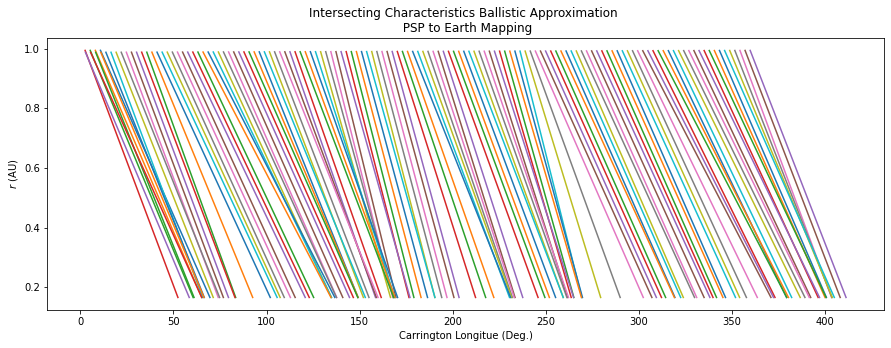

In [72]:
fig, ax = plt.subplots(figsize = (15,5))


for ii in np.arange(0, len(earth_coords.lon), 5):
    phi_location = (earth_coords.lon[ii].value)*(np.pi/180)
    radial_location = np.linspace(earth_coords.radius.to(u.km)[ii], r_min[0].to(u.km), nrout)
    curr_velocity = omni_data.quantity('V').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 
        _ = ax.plot(phi_shift_vec*(180/np.pi), radial_location.to(u.AU))

_ = ax.set_xlabel("Carrington Longitue (Deg.)")
_ = ax.set_ylabel("$r$ (AU)")
_ = ax.set_title("Intersecting Characteristics Ballistic Approximation \n PSP to Earth Mapping")

In [73]:
res_ballistic_b_min = apply_ballistic_approximation(omni_data.quantity('V').value, 
                                                    r_min.value[0] - r_min.value[-1], 
                                                    earth_coords.lon.to(u.radian).value)*180/np.pi
res_ballistic_b_mean = apply_ballistic_approximation(omni_data.quantity('V').value, 
                                                    r_mean.value[0] - r_mean.value[-1], 
                                                    earth_coords.lon.to(u.radian).value)*180/np.pi
res_ballistic_b_max = apply_ballistic_approximation(omni_data.quantity('V').value, 
                                                    r_max.value[0] - r_max.value[-1], 
                                                    earth_coords.lon.to(u.radian).value)*180/np.pi

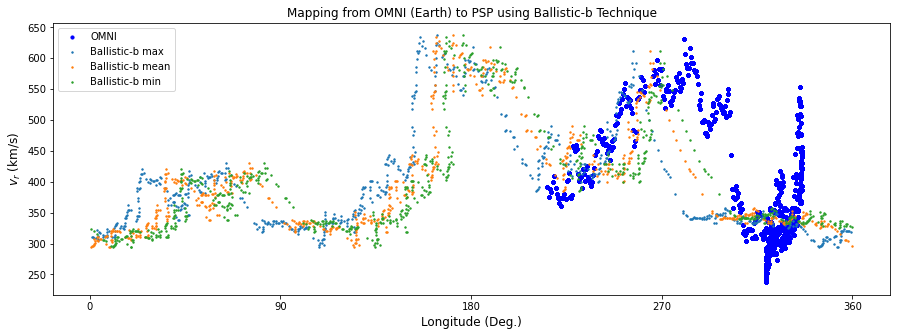

In [74]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(np.array(psp_coords.lon), psp_data.quantity('VR'), color="b", s=size, label="OMNI")

_ = ax.scatter(res_ballistic_b_max, omni_data.quantity('V'),s=2, label="Ballistic-b max")
_ = ax.scatter(res_ballistic_b_mean, omni_data.quantity('V'), s=2,label="Ballistic-b mean")
_ = ax.scatter(res_ballistic_b_min, omni_data.quantity('V').value, s=2,label="Ballistic-b min")

_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from OMNI (Earth) to PSP using Ballistic-b Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

# HUX-b Technique

# 1D interpolation - input $\phi$ ranges from [0, 2$\pi$]

In [75]:
# drop NaNs
nan_idx = np.isfinite(omni_data.quantity('V').value)
v_vec = omni_data.quantity('V').value[nan_idx]
interp = interpolate.interp1d(earth_coords.lon.value[nan_idx], \
                              v_vec, fill_value=(400, 400),  bounds_error=False)
omni_interp = interp(phi_array)

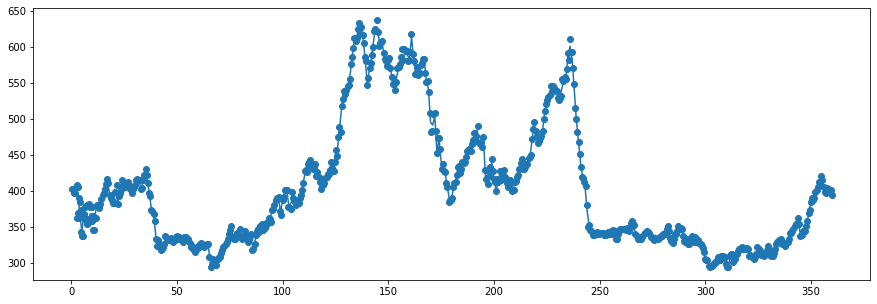

In [76]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(phi_array, omni_interp)
ax.scatter(earth_coords.lon.value, omni_data.quantity('V').value)

In [77]:
hux_b_full_res = apply_hux_b_model(r_final=omni_interp, 
                                         dr_vec=r_min.value[1:] - r_min.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_min[0].value, 
                                         add_v_acc=False).T

In [78]:
points = (phi_array, r_min)
xi = (psp_coords.lon.value, psp_coords.radius.value)
res_hux_b_interp = interpolate.interpn(points, hux_b_full_res, xi)

In [79]:
res_hux_b_min = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_min.value[1:] - r_min.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_min[0].value, 
                                         add_v_acc=False)

res_hux_b_mean = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_mean.value[1:] - r_mean.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_mean[0].value, 
                                         add_v_acc=False)

res_hux_b_max = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_max.value[1:] - r_max.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_max[0].value, 
                                         add_v_acc=False)

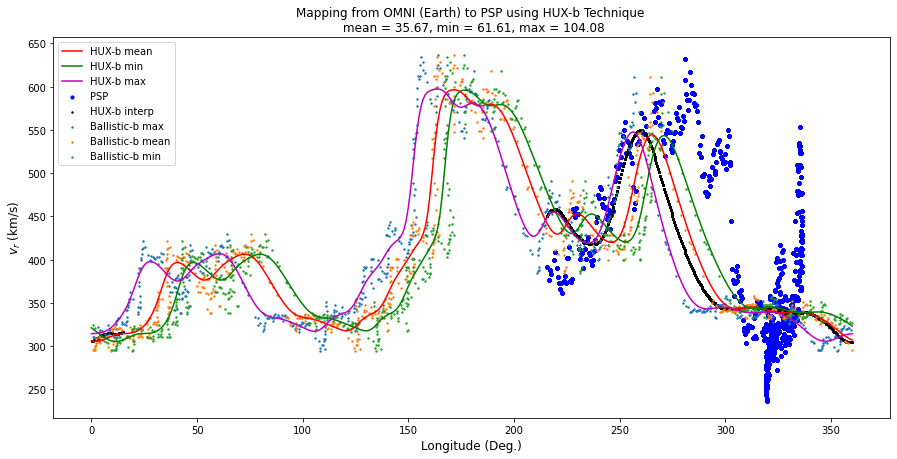

In [83]:
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.scatter(np.array(psp_coords.lon), psp_data.quantity('VR'), color="b", s=size, label="PSP")

_ = ax.plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean")
_ = ax.plot(phi_array, res_hux_b_min, color="g", label="HUX-b min")
_ = ax.plot(phi_array, res_hux_b_max, color="m", label="HUX-b max")
_ = ax.scatter(psp_coords.lon.value, res_hux_b_interp, color="k", s=2, label="HUX-b interp")


_ = ax.scatter(res_ballistic_b_max, omni_data.quantity('V'),s=2, label="Ballistic-b max")
_ = ax.scatter(res_ballistic_b_mean, omni_data.quantity('V'), s=2,label="Ballistic-b mean")
_ = ax.scatter(res_ballistic_b_min, omni_data.quantity('V').value, s=2,label="Ballistic-b min")

_ = ax.set_title("Mapping from OMNI (Earth) to PSP using HUX-b Technique \n mean = %.2f, min = %.2f, max = %.2f" % \
                       (np.min(psp_coords.radius).to(u.solRad).value,
                        np.mean(psp_coords.radius).to(u.solRad).value,
                        np.max(psp_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

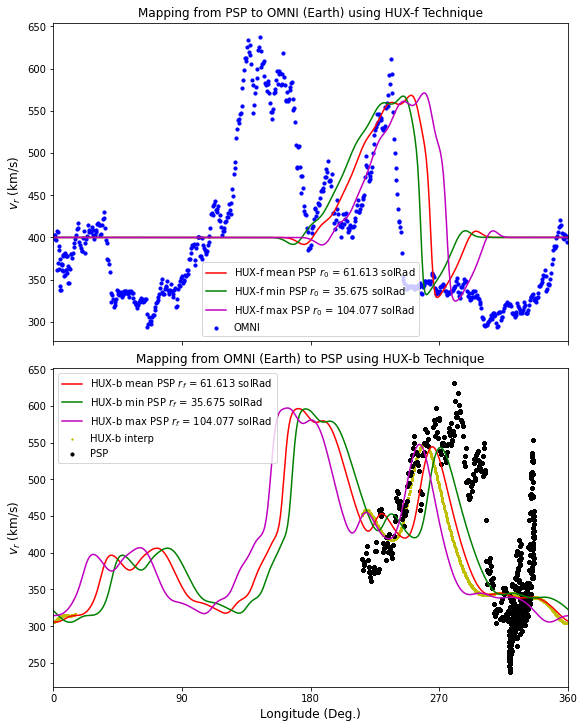

In [87]:
fig, ax = plt.subplots(nrows=2, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_xlim(0, 360)
ax[0].set_title("Mapping from PSP to OMNI (Earth) using HUX-f Technique", fontsize=fs1)
ax[0].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])

ax[0].scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

ax[0].plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean PSP $r_{0}$ = "+ 
           str(np.round(np.mean(psp_coords.radius).to(u.solRad), 3)))
ax[0].plot(phi_array, res_hux_f_min, color="g", label="HUX-f min PSP $r_{0}$ = "+ 
            str(np.round(np.min(psp_coords.radius).to(u.solRad), 3)))
ax[0].plot(phi_array, res_hux_f_max, color="m", label="HUX-f max PSP $r_{0}$ = " +
            str(np.round(np.max(psp_coords.radius).to(u.solRad), 3)))
ax[0].legend()


ax[1].set_xlim(0, 360)
ax[1].set_title("Mapping from OMNI (Earth) to PSP using HUX-b Technique", fontsize=fs1)
ax[1].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[1].set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])

ax[1].plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean PSP $r_{f}$ = "+ 
           str(np.round(np.mean(psp_coords.radius).to(u.solRad), 3)))
ax[1].plot(phi_array, res_hux_b_min, color="g", label="HUX-b min PSP $r_{f}$ = "+ 
            str(np.round(np.min(psp_coords.radius).to(u.solRad), 3)))
ax[1].plot(phi_array, res_hux_b_max, color="m", label="HUX-b max PSP $r_{f}$ = " +
            str(np.round(np.max(psp_coords.radius).to(u.solRad), 3)))
ax[1].scatter(psp_coords.lon.value, res_hux_b_interp, color="y", s=2, label="HUX-b interp")
ax[1].scatter(lon_psp, psp_data.quantity('VR'), color="k", s=size,label="PSP")


ax[1].legend()
#plt.savefig('figures/'+ case_study + '/mapping_omni_to_psp_and_back_cr' + str(cr) +'.png')

# Modified HUX Technique to Map non-uniform radial initial condition

In [88]:
# get longitude limits
min_lon = np.inf
max_lon = -np.inf

for ii in range(len(psp_coords.lon.value)):
    if psp_coords.lon.value[ii] < min_lon and not math.isnan(psp_data.quantity('VR').value[ii]):
        min_lon = psp_coords.lon.value[ii]
    if psp_coords.lon.value[ii] > max_lon and not math.isnan(psp_data.quantity('VR').value[ii]):
        max_lon = psp_coords.lon.value[ii]
print("min = ", min_lon)
print("max = ", max_lon)
print("closest index min = ")

min =  215.70859456700973
max =  336.0822784520752
closest index min = 


In [89]:
min_distance = np.abs(phi_array - min_lon)
max_distance = np.abs(phi_array - max_lon)

In [90]:
print("closest index min = ", min_distance.argmin())
print("closest index max = ", max_distance.argmin())

closest index min =  216
closest index max =  336


Text(0.5, 1.0, 'PSP Velocity')

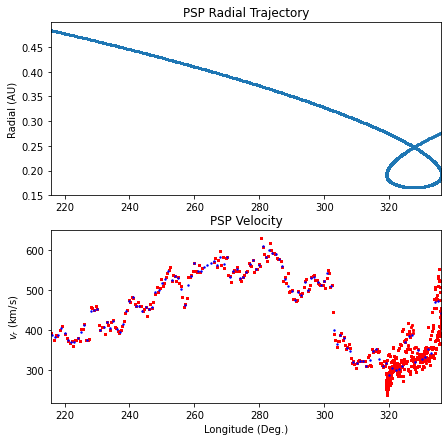

In [91]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
ax[0].scatter(psp_coords.lon, psp_traj.coords.radius.to(u.AU), s=2)
ax[1].scatter(psp_coords.lon, psp_data.quantity('VR'), s=2, c="r")
ax[1].scatter(phi_array, psp_interp, s=2, c="b")

ax[1].set_xlabel("Longitude (Deg.)")
ax[0].set_ylabel("Radial (AU)")
ax[1].set_ylabel(r'$v_{r}$ (km/s)')

ax[0].set_xlim(min_lon, max_lon)
ax[1].set_xlim(min_lon, max_lon)
ax[0].set_title("PSP Radial Trajectory")
ax[1].set_title("PSP Velocity")


## How to convert the initial radial trajectory to be single-valued?
1. keep the maximum value (will be continious yet does not include the extra propagation). 
2. Keep the minimum value (there will be discontinuities). 
3. linear interpolation maybe?

In [92]:
# create uniform phi 1d mesh grid. 
max_radial = np.max(psp_traj.coords.radius.to(u.km))
min_radial = np.min(psp_traj.coords.radius.to(u.km))

In [93]:
# drop NaNs
nan_idx = []

for ii, val in enumerate(psp_traj.coords.radius.to(u.km).value):
    if not math.isnan(val) and not math.isnan(psp_data.quantity('VR').value[ii]):
        nan_idx.append(ii)

In [94]:
r_vec = psp_traj.coords.radius.to(u.km)[nan_idx]

In [95]:
# First, lets examine the max-value approach. 
interp_radial = interpolate.interp1d(psp_coords.lon.value[nan_idx], \
                              r_vec, fill_value=(max_radial, (60 * u.solRad).to(u.km)),  kind='nearest-up', bounds_error=False)
psp_r_interp = interp_radial(phi_array)* u.km

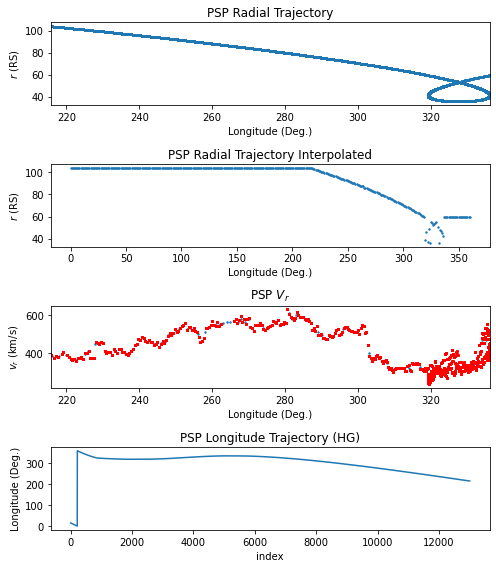

In [96]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 8))

ax[0].scatter(psp_coords.lon, psp_traj.coords.radius.to(u.solRad), s=2)
ax[1].scatter(phi_array, psp_r_interp.to(u.solRad), s=2)
ax[2].scatter(phi_array, psp_interp, s=2)
ax[2].scatter(psp_coords.lon.value, psp_data.quantity('VR').value, c="r", s=2)
ax[3].plot(psp_coords.lon)


ax[0].set_xlim(min_lon, max_lon)
#ax[1].set_xlim(min_lon, max_lon)
ax[2].set_xlim(min_lon, max_lon)

ax[0].set_title("PSP Radial Trajectory")
ax[1].set_title("PSP Radial Trajectory Interpolated")
ax[2].set_title("PSP $V_{r}$")
ax[3].set_title("PSP Longitude Trajectory (HG)")


ax[0].set_xlabel("Longitude (Deg.)")
ax[1].set_xlabel("Longitude (Deg.)")
ax[2].set_xlabel("Longitude (Deg.)")
ax[3].set_xlabel("index")



ax[0].set_ylabel("$r$ (RS)")
ax[1].set_ylabel("$r$ (RS)")
ax[2].set_ylabel("$v_{r}$ (km/s)")
ax[3].set_ylabel("Longitude (Deg.)")
plt.tight_layout()

The HUX underlying PDE

$$
-\Omega_{rot}\frac{\partial v_{r}}{\partial \phi} + v_{r}\frac{ \partial v_{r}}{\partial r}=0
$$

With the initial condition 
$$
v_{r}(\phi, r_{0}) = v_{r0}(\phi)
$$

If initial conidtion $r_{0}$ is non-uniform then we apply a radial boosting to the standard HUX mapping. Let $r_{psp}(\phi)$ be the radial trajectory of Parker Solar Probe (PSP) spacecraft and $v_{r_{psp}}(\phi)$ be the spacecraft observed solar wind velocity. The radial boosting will modify the initial condition to account for the spacecraft radial location, such that

$$
v_{i + 1, j} = 
\begin{equation} 
    \left\{
    \begin{array}{ll}
          v_{r_{psp}}(\phi_{j}) &  r_{psp}(\phi_{j}) \geq r_{i} \\
          v_{i, j} + \frac{\Delta r\Omega_{\text{rot}}}{\Delta \phi}  (\frac{v_{i, j+1} - v_{i, j}}{v_{i, j}})&  r_{psp}(\phi_{j}) < r_{i} \\
    \end{array} 
    \right. 
\end{equation}
$$

where mesh grid is defined as $r = [\min(r_{psp}), \max(r_{psp})]$ and $\phi = [0, 2\pi]$. The indexes $i$ and $j$ denote the radial ($r$) and longitude ($\phi$) grid indexing, respectively. After applying the radial boost, the initial condition is the velocity propagated up to $r_{\max} = \max(r_{psp})$. Then, we propagate from $r_{\max}$ out radially using the standard Heliospheric Upwind eXtrapolation Technique (HUX). 

In [97]:
mod_v = forward_radial_boosting(r_vec=psp_r_interp.value, v_vec=psp_interp, p_vec=phi_array*np.pi/180, nr=30)

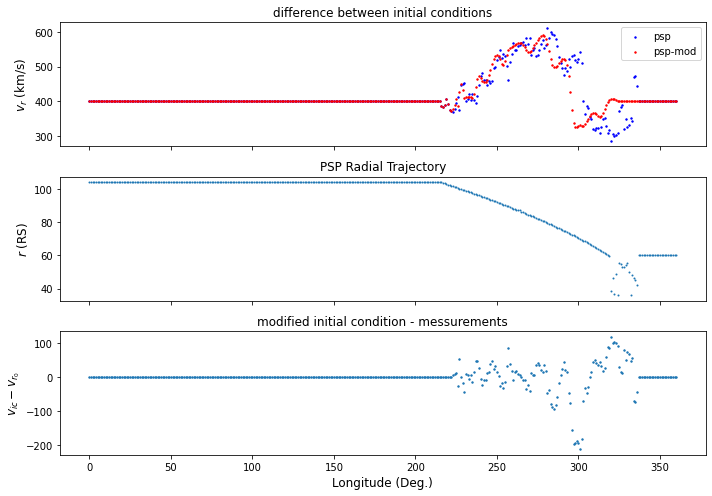

In [98]:
fig, ax = plt.subplots(nrows=3, ncols= 1, sharex=True, figsize=(10, 7))
ax[0].scatter(phi_array, psp_interp, c="b", label="psp", s=2)
ax[0].scatter(phi_array, mod_v, c="r", label="psp-mod", s=2)
ax[1].scatter(phi_array, psp_r_interp.to(u.solRad), s=1)
ax[2].scatter(phi_array, mod_v-psp_interp, s=2)
_ = ax[0].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
#_ = ax[0].set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax[1].set_ylabel("$r$ (RS)", fontsize=fs1)
#_ = ax[1].set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax[2].set_ylabel("$v_{ic} - v_{r_{0}}$", fontsize=fs1)
_ = ax[2].set_xlabel("Longitude (Deg.)", fontsize=fs1)


_ = ax[0].set_title('difference between initial conditions', fontsize=fs1)
_ = ax[1].set_title("PSP Radial Trajectory", fontsize=fs1)
_ = ax[2].set_title("modified initial condition - messurements", fontsize=fs1)
_ = ax[0].legend()
plt.tight_layout()

In [99]:
res_hux_f_mod = apply_forward_upwind_model(r_initial=mod_v,
                                        dr_vec=r_max.value[1:] - r_max.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_max[0].value)

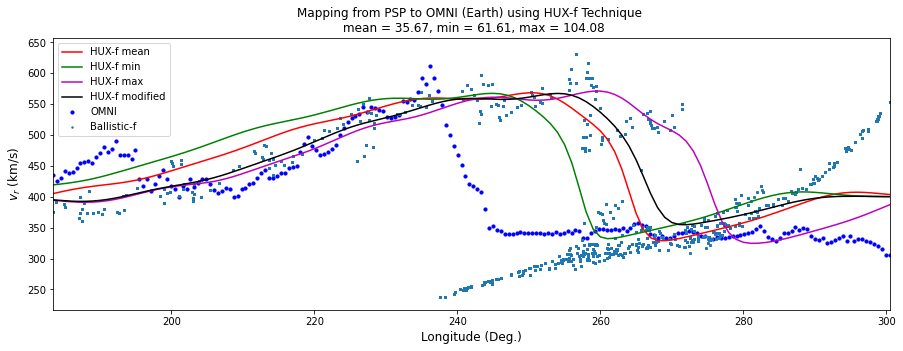

In [103]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean")
_ = ax.plot(phi_array, res_hux_f_min, color="g", label="HUX-f min")
_ = ax.plot(phi_array, res_hux_f_max, color="m", label="HUX-f max")
_ = ax.plot(phi_array, res_hux_f_mod, color="k", label="HUX-f modified")


_ = ax.scatter(res_ballistic_f*(180/np.pi), psp_data.quantity('VR'),s=2, label="Ballistic-f")

_ = ax.set_xlim(np.nanmin(res_ballistic_f)*(180/np.pi), np.nanmax(res_ballistic_f)*(180/np.pi))

_ = ax.set_title("Mapping from PSP to OMNI (Earth) using HUX-f Technique \n mean = %.2f, min = %.2f, max = %.2f" % \
                       (np.min(psp_coords.radius).to(u.solRad).value,
                        np.mean(psp_coords.radius).to(u.solRad).value,
                        np.max(psp_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

# Modified HUX-b to final velocity being in PSP radial trajectory.

First, we map OMNI messurements to $\max(r_{psp})$. Then we add an extra radial boost. This should work well in comparison to the modified HUX-f Technique since the messurements at OMNI cover the periodic longitude axis (HG) and therefore the initial condition is not extrapolated. 

Let $r_{psp}(\phi)$ be the radial trajectory of Parker Solar Probe (PSP) spacecraft and $v_{r_{psp}}(\phi)$ be PSP observed solar wind velocity. The radial boosting will modify the final velocity at PSP to account for the spacecraft radial location, such that

$$
v_{i + 1, j} = 
\begin{equation} 
    \left\{
    \begin{array}{ll}
          v_{i, j} &  r_{psp}(\phi_{j}) < r_{i} \\
          v_{i, j} + \frac{\Delta r\Omega_{\text{rot}}}{\Delta \phi}  (\frac{v_{i, j-1} - v_{i, j}}{v_{i, j}})&  r_{psp}(\phi_{j}) > r_{i} \\
    \end{array} 
    \right. 
\end{equation}
$$

where the mesh grid is defined as $r = [\min(r_{psp}), \max(r_{psp})]$ and $\phi = [0, 2\pi]$. The indexes $i$ and $j$ denote the radial ($r$) and longitude ($\phi$) grid indexing, respectively. This radial boost is applied after the standard HUX technqiue maps solar wind streams from OMNI (Earth) to $\max(r_{psp})$.

In [104]:
res_hux_b_mod = backwards_radial_boosting(r_vec=psp_r_interp.value, 
                                          v_vec=res_hux_b_max, 
                                          p_vec=phi_array*np.pi/180, 
                                          nr=30)

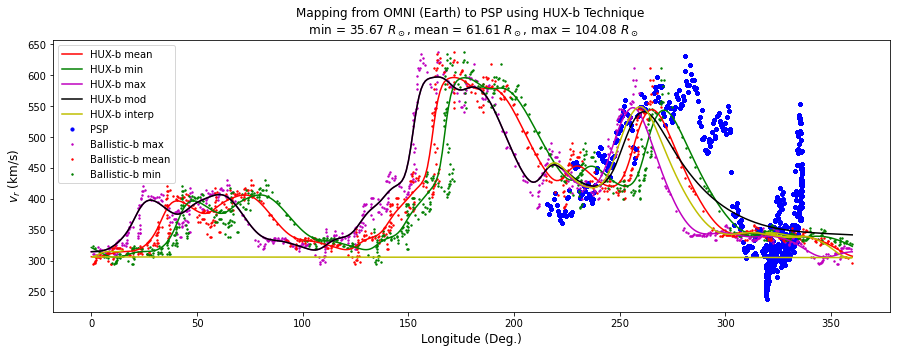

In [105]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(np.array(psp_coords.lon), psp_data.quantity('VR'), color="b", s=size, label="PSP")

_ = ax.plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean")
_ = ax.plot(phi_array, res_hux_b_min, color="g", label="HUX-b min")
_ = ax.plot(phi_array, res_hux_b_max, color="m", label="HUX-b max")
_ = ax.plot(phi_array, res_hux_b_mod, color="k", label="HUX-b mod")
_ = ax.plot(psp_coords.lon.value, res_hux_b_interp, color="y", label="HUX-b interp")



_ = ax.scatter(res_ballistic_b_max, omni_data.quantity('V'),  color="m", s=2, label="Ballistic-b max")
_ = ax.scatter(res_ballistic_b_mean, omni_data.quantity('V'),  color="r", s=2,label="Ballistic-b mean")
_ = ax.scatter(res_ballistic_b_min, omni_data.quantity('V').value, color="g",  s=2,label="Ballistic-b min")

_ = ax.set_title("Mapping from OMNI (Earth) to PSP using HUX-b Technique \n min = %.2f $R_\odot$, mean = %.2f $R_\odot$, max = %.2f $R_\odot$" % \
                       (np.min(psp_coords.radius).to(u.solRad).value,
                        np.mean(psp_coords.radius).to(u.solRad).value,
                        np.max(psp_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

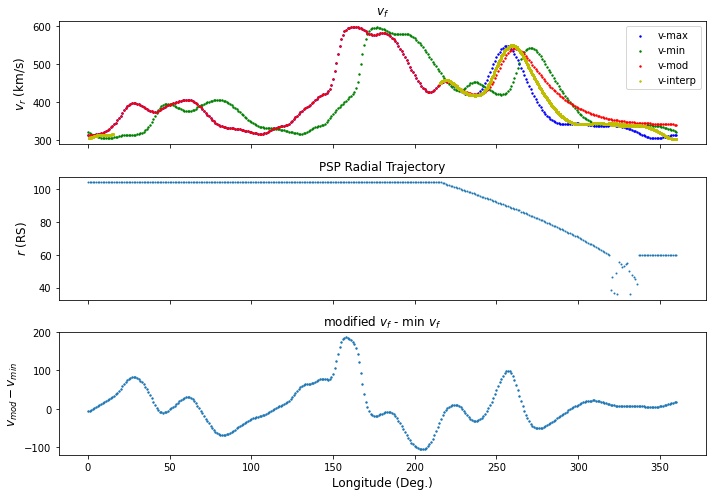

In [106]:
fig, ax = plt.subplots(nrows=3, ncols= 1, sharex=True, figsize=(10, 7))
ax[0].scatter(phi_array, res_hux_b_max, c="b", label="v-max", s=2)
ax[0].scatter(phi_array, res_hux_b_min, c="g", label="v-min", s=2)
ax[0].scatter(phi_array, res_hux_b_mod, c="r", label="v-mod", s=2)
ax[0].scatter(psp_coords.lon.value, res_hux_b_interp, color="y", s=2, label="v-interp")
ax[1].scatter(phi_array, psp_r_interp.to(u.solRad), s=1)
ax[2].scatter(phi_array, res_hux_b_mod- res_hux_b_min, s=2)
_ = ax[0].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax[1].set_ylabel("$r$ (RS)", fontsize=fs1)
_ = ax[2].set_ylabel("$v_{mod} - v_{min}$", fontsize=fs1)
_ = ax[2].set_xlabel("Longitude (Deg.)", fontsize=fs1)


_ = ax[0].set_title('$v_{f}$', fontsize=fs1)
_ = ax[1].set_title("PSP Radial Trajectory", fontsize=fs1)
_ = ax[2].set_title("modified $v_{f}$ - min $v_{f}$", fontsize=fs1)
_ = ax[0].legend()
plt.tight_layout()

### Propagated Error of HUX-f for PSP in-situ  velocity 

![](figures/literature/hux-stencil.PNG)

In [107]:
print("closest index min = ", min_distance.argmin())
print("closest index max = ", max_distance.argmin())

closest index min =  216
closest index max =  336


Assume we have $m$ mesh points in $\phi$ grid and $n$ mesh points in $r$ grid. Since PSP does not cover the full Sun latitude in HG coordinates, we extrapolate the velocity profile at PSP. In order to examine the propaged error from such extraplation, we evaluate the forward sencil on the given $\phi/r$ mesh grid.  


For forward propagation, it is visible from the upwind stencil that error is propagated from the east. Let the longitude axis be a modest uniform mesh $\Delta \phi = 1  ^{\circ}$ where $m= 360$, and the radial axis have 100 mesh points, meaning $\Delta r = 1.102 R_\odot$ In the case of PSP perihelion 1 (P1), we are able to gather the solar wind stream radial speed from $216^{\circ}$ to $336^{\circ}$ in longitude (HG coordinates). Consequently, when mapping to 1 AU (Earth) the indices between [336, 360] and [0, 216] can contribute to the propagated error. 

Therefore the value at index 336 will contribute to the value at index $336-100 = 236$ after propagation. 
